# k-Nearest Neighbors for Steering Classification

This notebook trains and evaluates k-Nearest Neighbors (kNN) on the steering image dataset.

**Key Concepts:**
- Instance-based learning (no explicit training phase)
- Non-linear decision boundaries
- Distance-based classification (majority vote among k neighbors)

**Bias-Variance Tradeoff:**
- k=1: Low bias, high variance (unstable, sensitive to noise)
- Large k: Higher bias, lower variance (more stable, smoother boundaries)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
import warnings
warnings.filterwarnings('ignore')

# Import shared utilities
from utils import (
    load_data, preprocess_data, evaluate_model, 
    save_results, print_class_distribution, CLASSES, RANDOM_STATE
)

print("Libraries loaded successfully!")


Libraries loaded successfully!


## 1. Load and Preprocess Data


In [2]:
# Load data
data = load_data()

X_raw, y_raw = data['raw']
X_eng, y_eng, feature_names = data['engineered']

print(f"\nRaw features shape: {X_raw.shape}")
print(f"Engineered features shape: {X_eng.shape}")


Loaded 9900 raw images
  Shape: (9900, 4096)
  Class distribution: {np.str_('forward'): np.int64(7343), np.str_('left'): np.int64(1620), np.str_('right'): np.int64(937)}
Loaded 9900 samples with 38 engineered features
  Class distribution: {'forward': np.int64(7343), 'left': np.int64(1620), 'right': np.int64(937)}

Raw features shape: (9900, 4096)
Engineered features shape: (9900, 38)


In [3]:
# Preprocess raw data with PCA (important for kNN - reduces curse of dimensionality)
print("Preprocessing RAW data with PCA:")
raw_processed = preprocess_data(
    X_raw, y_raw, 
    test_size=0.2, 
    apply_pca_reduction=True, 
    pca_variance=0.95,
    scale=True  # Scaling is critical for kNN!
)

print("\nPreprocessing ENGINEERED data:")
eng_processed = preprocess_data(
    X_eng, y_eng, 
    test_size=0.2, 
    apply_pca_reduction=False,
    scale=True
)

print("\nTraining set class distribution:")
print_class_distribution(raw_processed['y_train'], raw_processed['label_encoder'])


Preprocessing RAW data with PCA:
Train/Test split: 7920/1980 samples
PCA: 4096 features -> 65 components
  Variance retained: 95.01%

Preprocessing ENGINEERED data:
Train/Test split: 7920/1980 samples

Training set class distribution:
Class Distribution:
  forward: 5874 (74.2%)
  left: 1296 (16.4%)
  right: 750 (9.5%)


## 2. Hyperparameter Tuning for k

Use cross-validation to find the optimal number of neighbors (k).
- Small k: More flexible, risk of overfitting
- Large k: More stable, risk of underfitting


In [4]:
# Cross-validation to find optimal k for RAW features
print("Finding optimal k for RAW (PCA) features...")

k_range = range(1, 31, 2)  # Test odd values from 1 to 29
cv_scores_raw = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance', n_jobs=-1)
    scores = cross_val_score(knn, raw_processed['X_train'], raw_processed['y_train'], 
                             cv=skf, scoring='f1_macro')
    cv_scores_raw.append((k, scores.mean(), scores.std()))
    print(f"  k={k:2d}: F1={scores.mean():.4f} (+/- {scores.std()*2:.4f})")

# Find best k
best_k_raw = max(cv_scores_raw, key=lambda x: x[1])
print(f"\nBest k for RAW features: {best_k_raw[0]} (F1={best_k_raw[1]:.4f})")


Finding optimal k for RAW (PCA) features...
  k= 1: F1=0.8569 (+/- 0.0169)
  k= 3: F1=0.8744 (+/- 0.0157)
  k= 5: F1=0.8758 (+/- 0.0184)
  k= 7: F1=0.8746 (+/- 0.0176)
  k= 9: F1=0.8709 (+/- 0.0221)
  k=11: F1=0.8696 (+/- 0.0186)
  k=13: F1=0.8703 (+/- 0.0175)
  k=15: F1=0.8698 (+/- 0.0185)
  k=17: F1=0.8678 (+/- 0.0225)
  k=19: F1=0.8671 (+/- 0.0211)
  k=21: F1=0.8631 (+/- 0.0227)
  k=23: F1=0.8635 (+/- 0.0255)
  k=25: F1=0.8621 (+/- 0.0256)
  k=27: F1=0.8611 (+/- 0.0227)
  k=29: F1=0.8613 (+/- 0.0227)

Best k for RAW features: 5 (F1=0.8758)


In [5]:
# Cross-validation to find optimal k for ENGINEERED features
print("Finding optimal k for ENGINEERED features...")

cv_scores_eng = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance', n_jobs=-1)
    scores = cross_val_score(knn, eng_processed['X_train'], eng_processed['y_train'], 
                             cv=skf, scoring='f1_macro')
    cv_scores_eng.append((k, scores.mean(), scores.std()))
    print(f"  k={k:2d}: F1={scores.mean():.4f} (+/- {scores.std()*2:.4f})")

# Find best k
best_k_eng = max(cv_scores_eng, key=lambda x: x[1])
print(f"\nBest k for ENGINEERED features: {best_k_eng[0]} (F1={best_k_eng[1]:.4f})")


Finding optimal k for ENGINEERED features...
  k= 1: F1=0.7580 (+/- 0.0152)
  k= 3: F1=0.7682 (+/- 0.0211)
  k= 5: F1=0.7727 (+/- 0.0209)
  k= 7: F1=0.7744 (+/- 0.0203)
  k= 9: F1=0.7728 (+/- 0.0182)
  k=11: F1=0.7689 (+/- 0.0266)
  k=13: F1=0.7583 (+/- 0.0263)
  k=15: F1=0.7560 (+/- 0.0289)
  k=17: F1=0.7495 (+/- 0.0279)
  k=19: F1=0.7495 (+/- 0.0299)
  k=21: F1=0.7455 (+/- 0.0424)
  k=23: F1=0.7414 (+/- 0.0412)
  k=25: F1=0.7356 (+/- 0.0431)
  k=27: F1=0.7334 (+/- 0.0377)
  k=29: F1=0.7304 (+/- 0.0463)

Best k for ENGINEERED features: 7 (F1=0.7744)


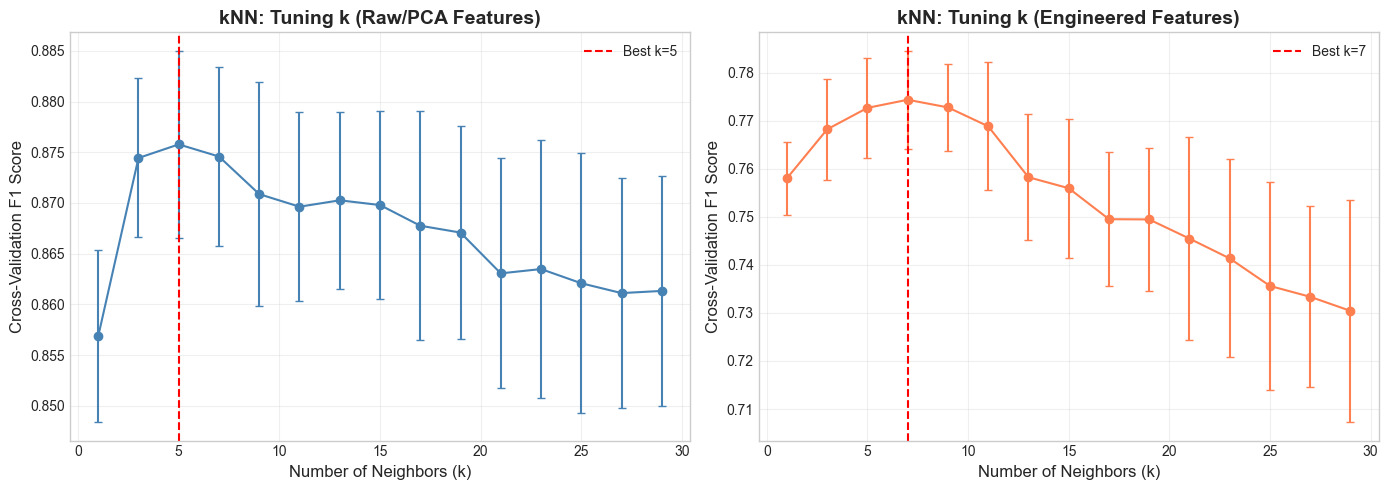

In [6]:
# Visualize k selection
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Raw features
ks = [x[0] for x in cv_scores_raw]
means_raw = [x[1] for x in cv_scores_raw]
stds_raw = [x[2] for x in cv_scores_raw]

axes[0].errorbar(ks, means_raw, yerr=stds_raw, marker='o', capsize=3, color='steelblue')
axes[0].axvline(x=best_k_raw[0], color='red', linestyle='--', label=f'Best k={best_k_raw[0]}')
axes[0].set_xlabel('Number of Neighbors (k)', fontsize=12)
axes[0].set_ylabel('Cross-Validation F1 Score', fontsize=12)
axes[0].set_title('kNN: Tuning k (Raw/PCA Features)', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Engineered features
means_eng = [x[1] for x in cv_scores_eng]
stds_eng = [x[2] for x in cv_scores_eng]

axes[1].errorbar(ks, means_eng, yerr=stds_eng, marker='o', capsize=3, color='coral')
axes[1].axvline(x=best_k_eng[0], color='red', linestyle='--', label=f'Best k={best_k_eng[0]}')
axes[1].set_xlabel('Number of Neighbors (k)', fontsize=12)
axes[1].set_ylabel('Cross-Validation F1 Score', fontsize=12)
axes[1].set_title('kNN: Tuning k (Engineered Features)', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 3. Train Final Models with Optimal k


Training kNN (k=5) on RAW (PCA) features...

Model: kNN (k=5) | Features: raw
Accuracy:          0.9253
Balanced Accuracy: 0.8724
Macro F1:          0.8852
Weighted F1:       0.9245
Macro Precision:   0.8991
Macro Recall:      0.8724
ROC-AUC (macro):   0.9657

Per-class metrics:
  forward   : F1=0.9501, Precision=0.9406, Recall=0.9598
  left      : F1=0.8453, Precision=0.8746, Recall=0.8179
  right     : F1=0.8603, Precision=0.8820, Recall=0.8396

Classification Report:
              precision    recall  f1-score   support

     forward       0.94      0.96      0.95      1469
        left       0.87      0.82      0.85       324
       right       0.88      0.84      0.86       187

    accuracy                           0.93      1980
   macro avg       0.90      0.87      0.89      1980
weighted avg       0.92      0.93      0.92      1980



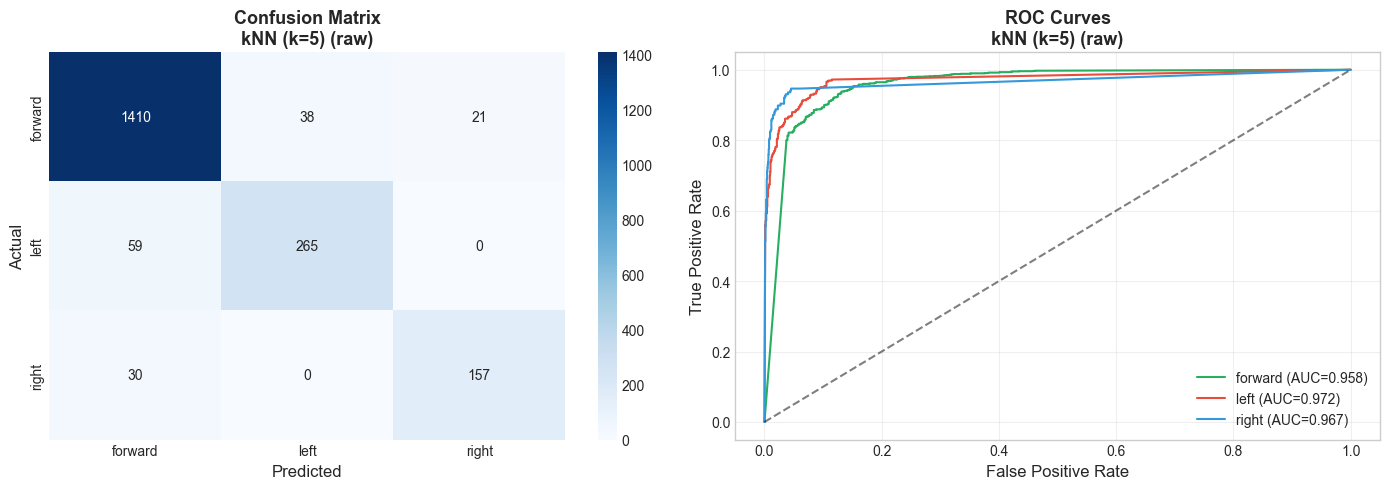

In [7]:
# Train kNN with optimal k on RAW (PCA) features
print(f"Training kNN (k={best_k_raw[0]}) on RAW (PCA) features...")

knn_raw = KNeighborsClassifier(
    n_neighbors=best_k_raw[0],
    weights='distance',  # Weight by inverse distance
    metric='euclidean',
    n_jobs=-1
)

knn_raw.fit(raw_processed['X_train'], raw_processed['y_train'])

results_knn_raw = evaluate_model(
    knn_raw,
    raw_processed['X_test'],
    raw_processed['y_test'],
    model_name=f'kNN (k={best_k_raw[0]})',
    feature_type='raw',
    label_encoder=raw_processed['label_encoder']
)


Training kNN (k=7) on ENGINEERED features...

Model: kNN (k=7) | Features: engineered
Accuracy:          0.8727
Balanced Accuracy: 0.7382
Macro F1:          0.7894
Weighted F1:       0.8655
Macro Precision:   0.8665
Macro Recall:      0.7382
ROC-AUC (macro):   0.9406

Per-class metrics:
  forward   : F1=0.9181, Precision=0.8782, Recall=0.9619
  left      : F1=0.6846, Precision=0.8162, Recall=0.5895
  right     : F1=0.7654, Precision=0.9051, Recall=0.6631

Classification Report:
              precision    recall  f1-score   support

     forward       0.88      0.96      0.92      1469
        left       0.82      0.59      0.68       324
       right       0.91      0.66      0.77       187

    accuracy                           0.87      1980
   macro avg       0.87      0.74      0.79      1980
weighted avg       0.87      0.87      0.87      1980



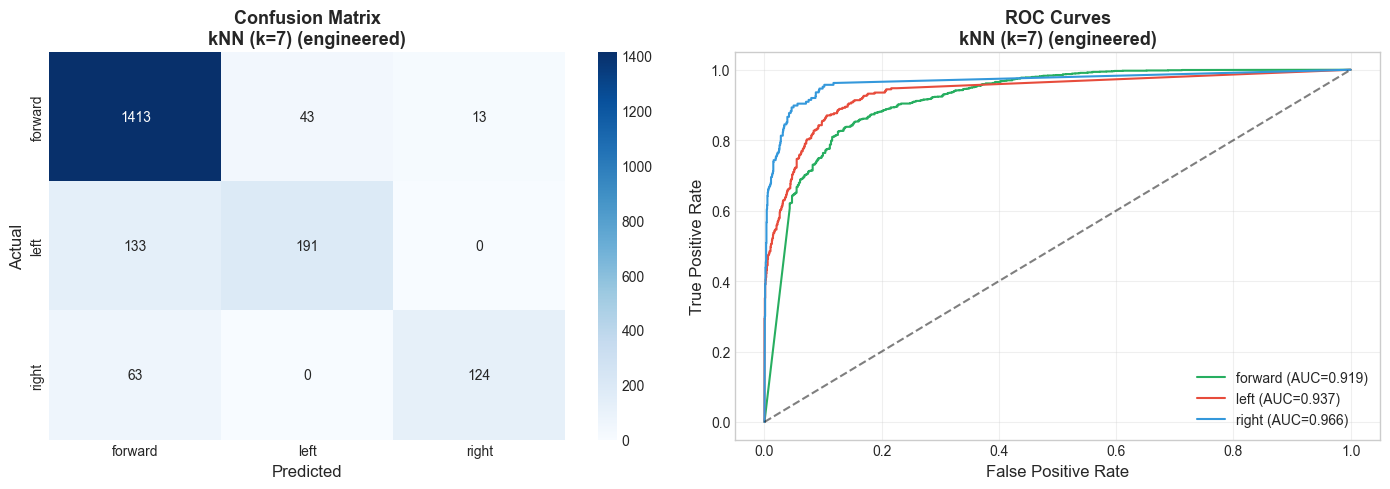

In [8]:
# Train kNN with optimal k on ENGINEERED features
print(f"Training kNN (k={best_k_eng[0]}) on ENGINEERED features...")

knn_eng = KNeighborsClassifier(
    n_neighbors=best_k_eng[0],
    weights='distance',
    metric='euclidean',
    n_jobs=-1
)

knn_eng.fit(eng_processed['X_train'], eng_processed['y_train'])

results_knn_eng = evaluate_model(
    knn_eng,
    eng_processed['X_test'],
    eng_processed['y_test'],
    model_name=f'kNN (k={best_k_eng[0]})',
    feature_type='engineered',
    label_encoder=eng_processed['label_encoder']
)


## 4. Results Summary


In [9]:
# Summary
all_results = [results_knn_raw, results_knn_eng]

summary_df = pd.DataFrame([
    {
        'Model': r['model_name'],
        'Features': r['feature_type'],
        'Accuracy': r['accuracy'],
        'Balanced Acc': r['balanced_accuracy'],
        'F1 (Macro)': r['f1_macro'],
        'ROC-AUC': r['roc_auc']
    }
    for r in all_results
])

print("\n" + "="*80)
print("kNN RESULTS SUMMARY")
print("="*80)
print(summary_df.to_string(index=False))



kNN RESULTS SUMMARY
    Model   Features  Accuracy  Balanced Acc  F1 (Macro)  ROC-AUC
kNN (k=5)        raw  0.925253      0.872437    0.885235 0.965739
kNN (k=7) engineered  0.872727      0.738162    0.789383 0.940597


In [10]:
# Save results
save_results(all_results, 'knn')
print("Results saved successfully!")


Results saved to ../../data/model_results/knn_results.json
Results saved successfully!


## 5. Key Observations

### kNN Characteristics
- **Memory-based**: No explicit training phase; all computation at prediction time
- **Non-parametric**: Makes no assumptions about data distribution
- **Distance-sensitive**: Feature scaling is critical

### Performance Considerations
- PCA helps reduce "curse of dimensionality" for raw pixel data
- Engineered features may provide more meaningful distance metrics
- Class imbalance affects neighbor composition

### Computational Cost
- Prediction time scales with training set size
- For large datasets, consider approximate nearest neighbor methods
